# Notebook Configuration

In [2]:
import torch
import torchvision.transforms as transforms
#Import VGG19
from torchvision.models import resnet18, vgg19, resnet50
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import json
import numpy as np

%cd /app/

/app


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
#Read information json:
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
PATH_SLICES = '/Datasets/PICAI_32x32x12/slices/' # Format -> idPatient_000i_sj.npy
                                                 # Where i = [0,1,2] and j = [1,2,3]

with open(PATH_JSON_INFO, 'r') as f:   # -> case_ISUP is the label
    info = json.load(f)

In [4]:
gpu = "0" #iF YOU WANT TO USE GPU
# gpu = None 

#----------------------------------------------------------------
# Selecting the device
#----------------------------------------------------------------
if gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu #aca se pone nuemro de grafica libre

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:',os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")
#

Using GPU: NVIDIA GeForce GTX 750 Ti
CUDA Visible devices: 0


# Loading Dataset

The dataset consist on slices that where previously standarized by volume

In [110]:
from torchsummary import summary

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.idPatients = list(info.keys())
        
    def __len__(self):
        return len(self.idPatients)
    
    def __getitem__(self, idx):
        mods = ["0","1","2"]
        slis = ["1","2","3"]
        idPatient = self.idPatients[idx]
        
        image_list = []

        for i in range(3):
            for j in range(3):
                local_path =  idPatient + "_000" +mods[i]+ "_s" + slis[j] + ".npy"
                print(local_path)
                image_path = os.path.join(self.image_dir,local_path)
                image = np.load(image_path)
                print("done")
                image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
                image_list.append(image)
                
        #Concat images on the batch dimension
        tensor = np.stack(image_list, axis=2)
        tensor.shape
        return tensor, idPatient


dataset = ImageDataset(PATH_SLICES)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [90]:
# Load pretrained CNN model
cnn_model = vgg19(pretrained=True)#.to(device)
cnn_model = torch.nn.Sequential(*list(cnn_model.children())[0][:5])#.to(device)  # Remove the fully connected layers
cnn_model.eval()
#summary(cnn_model, (3, 32, 32))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [111]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import sys

def create_graph_from_features(features):
    G = nx.Graph()
    num_nodes = features.shape[0]
    # Add nodes, each node feature is the feature vector of the corresponding image

    for i in range(num_nodes):
        G.add_node(i, feature=features[i,:])
    
    # Compute similarity and add edges
    similarity_matrix = cosine_similarity(features)

    #Define the threshold to preserve 25% of the similarity matrix
    threshold = np.percentile(similarity_matrix, 85)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] > threshold:  # Threshold can be adjusted
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    
    #If a node has no connections drop the node and the row and column on similarity matrices
    nodes_to_remove = []
    for node in G.nodes:
        if G.degree(node) == 0:
            nodes_to_remove.append(node)
    
    G.remove_nodes_from(nodes_to_remove)

    return G

graphs = []
labels = []
i = 0

for image, idPatient in dataloader:
    with torch.no_grad():
        #Change image to float tensor   
        image = image.type(torch.FloatTensor)#.to(device)
        features = cnn_model(image).squeeze()
        #Vectorize the last two axis
        break
        features = features.view(features.size(0), -1).cpu().numpy()
        graph = create_graph_from_features(features)
        graphs.append(graph)
        labels.append(info[idPatient[0]]['case_ISUP'])        
        break


11107_1001130_0000_s1.npy
done
11107_1001130_0000_s2.npy


FileNotFoundError: [Errno 2] No such file or directory: '/Datasets/PICAI_32x32x12/slices/11107_1001130_0000_s2.npy'

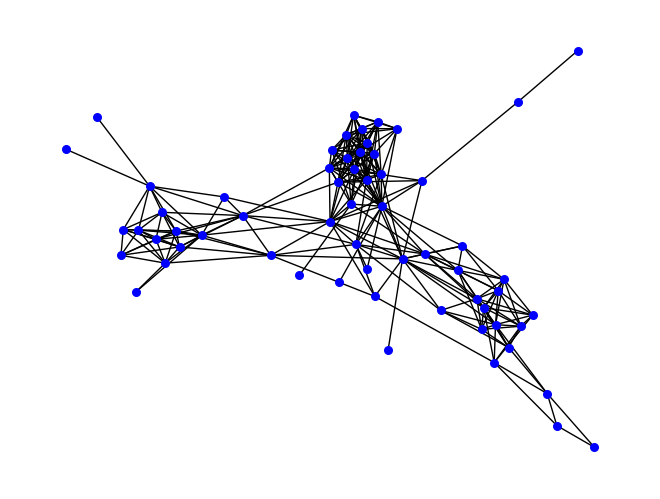

61


In [92]:
#Plot the graph

import matplotlib.pyplot as plt

def plot_graph(graph):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=30, node_color='blue')
    plt.show()

plot_graph(graphs[i])
print(len(graphs[i].nodes))